In [12]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.dates as mpl_dates
import math, dateutil.parser, datetime, sys, pandas_market_calendars as mcal

from statsmodels.stats.weightstats import DescrStatsW
from datetime import date

from scipy import stats
import yfinance as yf

yf.pdr_override()
import pandas_datareader.data as pdr

import pandas as pd
import pandas_market_calendars as mcal
import pandas_datareader as pdr
import datetime
import numpy as np
from scipy import stats
from statsmodels.stats.weightstats import DescrStatsW
import math
from datetime import date

# Function to construct the initial DataFrame from a CSV file
def constructDF():
    SP500 = pd.read_csv('SPX_Data.csv')
    SP500.index = pd.to_datetime(SP500['Date'], format='mixed')
    SP500.drop(columns=['Date','Volume','Adj Close**'], inplace=True)
    return SP500

# Function to update data by fetching new stock market data and appending it to the CSV file
def update_data():
    nyse = mcal.get_calendar('NYSE')
    today = date.today()
    SP500 = constructDF()
    last_saved_date = SP500.index[-1]
    last_date_forward = (last_saved_date + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    last_traded =  pd.to_datetime(today) - pd.tseries.offsets.CustomBusinessDay(0, holidays = nyse.holidays().holidays)
    if last_saved_date != last_traded:
        print(last_saved_date, last_traded)
        SPX = pdr.get_data_yahoo('^GSPC', last_date_forward)
        SPX = SPX.reindex(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
        SPX = SPX.round(2)
        with open('SPX_Data.csv', 'a+') as file:  # Open the CSV file in append mode
            file.seek(0, 2)
            last_char = file.read(1)
            if last_char != '\n':
                file.write('\n')  # Add a new line if the last character is not a newline
        SPX.to_csv('SPX_Data.csv', mode='a', header=False, encoding=None)  # Append new data to the CSV file
    else:
        print('data up to date')
    return SP500

# Function to add weight to a particular month in the DataFrame
def add_weight(row):
        return 2 if row['Month'] == 9 else 1  # Add weight to a particular month

# Main function
if __name__ == "__main__":
    # Update the data
    SP500 = update_data()

    # Calculate log returns, month, day, daily returns, and add weight to the DataFrame
    SP500['Log_Returns'] = np.log(SP500['Close']) - np.log(SP500['Close'].shift(1))
    SP500['Month'] = pd.DatetimeIndex(SP500.index).month
    SP500['Day'] = pd.DatetimeIndex(SP500.index).day
    SP500['Daily Returns'] = SP500['Close'].pct_change()
    SP500['Weight'] = SP500.apply(add_weight, axis=1)
    SP500.dropna(inplace=True)

    # Function to simulate price paths using Inverse Cumulative Distribution Function (ICDF)
    def price_sim_ICDF(SP500, sims, periods):
        last_close = SP500['Close'].iat[-1]
        last_date = SP500.index[-1]
        
        log_returns = SP500['Log_Returns']
        mu = np.average(log_returns)
        std = np.std(log_returns)
        variance = np.var(log_returns)
        drift = mu - .5 * variance

        weighted_mu = np.average(log_returns, weights=SP500['Weight'])
        weighted_std= DescrStatsW(log_returns, weights=SP500['Weight']).std
        mu_by_month = SP500.groupby(pd.Grouper(key="Month")).mean()

        print('non-weighted average log returns: {0:.5%}'.format(mu))
        print('non-weighted standard deviation: {0:.5%}'.format(std))
        
        print('\nweighted average log returns: {0:.5%}'.format(weighted_mu))
        print('weighted standard deviation: {0:.5%}'.format(weighted_std))
        
        # print(mu_by_month)
        print(SP500.tail(5))
        
        sim_paths = [0]*sims

        for s in range(0, sims):
            
            q = np.random.rand(periods)
            Z = stats.norm.ppf(q, loc=weighted_mu, scale=weighted_std)

            daily_returns = pow(math.e, (drift + weighted_std * Z))
            
            price_paths = [{} for i in range(periods)]
            price_paths[0]['Date'] = last_date
            price_paths[0]['Close'] = last_close
            previous_date = price_paths[0]['Date']
            
            for t in range(1, periods):
                
                previous_date = price_paths[t-1]['Date']
                new_date = previous_date + datetime.timedelta(days=1)
                price_paths[t]['Date'] = new_date
                price_paths[t]['Close'] = price_paths[t-1]['Close'] * daily_returns[t]

            sim_paths[s] = price_paths

        return sim_paths
        
    forward_days, sims = 30, 10000  # Define the number of forward days and simulation count
    
    # Function to call price_sim_ICDF with predefined parameters
    def myfunc():
        return price_sim_ICDF(SP500, sims, forward_days)

    # Call the simulation function
    sim_paths = myfunc()

    print(sim_paths[0][-1])
    def plot_price_paths_whs(sim_paths):
        
#      -------------- plot historical --------------

#         date = pd.to_datetime(SP500['Date'])
#         close = SP500['Close']
#         plt.plot(date, close, linestyle='--', )
#         plt.title('SPX Price')
#         plt.ylabel('Close Price')

#      -------------- plot historical --------------

        sim_ending_prices = []
        
        for path in sim_paths:
            
            df = pd.DataFrame.from_dict(path)
            date = pd.to_datetime(df['Date'])
            last_date = date.iat[-1]
            target_date = last_date + datetime.timedelta(days=1)
            close = df['Close']
#             plt.plot(date, close, linestyle='-', )

            sim_ending_prices.append(path[-1]['Close'])

#         date_format=mpl_dates.DateFormatter("%Y-%m-%d")
#         plt.gcf().autofmt_xdate() #remove if needed
#         plt.gca().xaxis.set_major_formatter(date_format)
#         plt.show()
        
        target_date = target_date.strftime("%m/%d/%Y")
        plt.hist(sim_ending_prices, bins=50, density=True)
        plt.title(f'Simulated close price on {target_date}')
        plt.axvline(np.percentile(sim_ending_prices,5), color='r', linestyle='dashed', linewidth=2)
        plt.axvline(np.percentile(sim_ending_prices,95), color='r', linestyle='dashed', linewidth=2)
        plt.axvline(np.percentile(sim_ending_prices,50), color='b', linestyle='dashed', linewidth=2)
        plt.show()
    # ------------ method for plotting historical + price paths ------------

data up to date
non-weighted average log returns: 0.02291%
non-weighted standard deviation: 1.20011%

weighted average log returns: 0.01606%
weighted standard deviation: 1.20991%
               Open     High      Low    Close  Log_Returns  Month  Day   
Date                                                                      
2023-10-12  4380.94  4385.85  4325.43  4349.61    -0.006266     10   12  \
2023-10-13  4360.49  4377.10  4311.97  4327.78    -0.005031     10   13   
2023-10-16  4342.37  4383.33  4342.37  4373.63     0.010539     10   16   
2023-10-17  4345.23  4393.57  4337.54  4373.20    -0.000098     10   17   
2023-10-18  4357.35  4364.20  4303.84  4314.60    -0.013490     10   18   

            Daily Returns  Weight  
Date                               
2023-10-12      -0.006246       1  
2023-10-13      -0.005019       1  
2023-10-16       0.010594       1  
2023-10-17      -0.000098       1  
2023-10-18      -0.013400       1  
{'Date': Timestamp('2023-11-16 00:00:00'), 

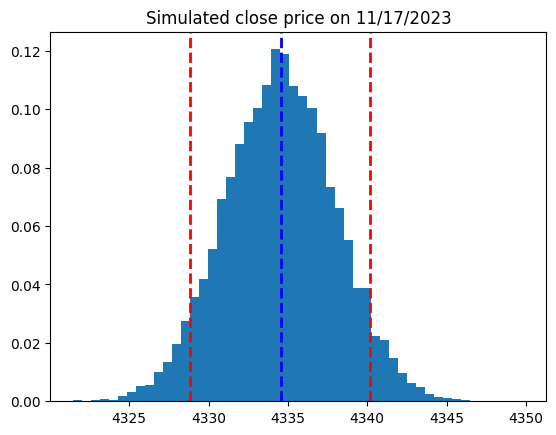

In [8]:
plot_price_paths_whs(sim_paths)
# print(myfunc())

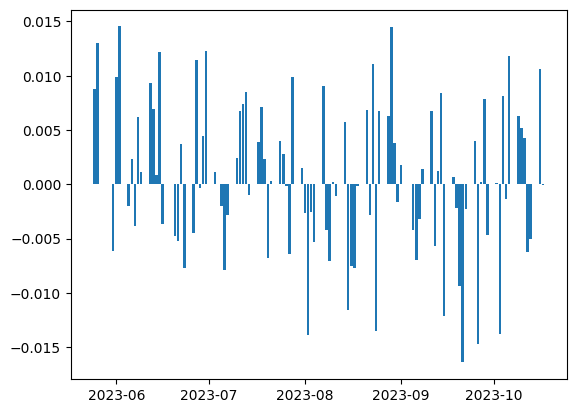

In [27]:
SP500 = SP500.iloc[-100:]
date = SP500.index
daily_changes = SP500['Daily Returns']
# plt.plot(date, daily_changes, 'go')
plt.bar(date, daily_changes)

def test(x, a, b):
    return a * np.sin(b * x)

# a = pd.DataFrame({'price':[50, 100, 150, 75]})
# a['delta'] = a['price'].pct_change()
# a.iloc[-1:]
# plt.plot(date, ln_chng)

In [11]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.dates as mpl_dates
import sys, os, math, dateutil.parser, datetime, sys, pandas_market_calendars as mcal

from statsmodels.stats.weightstats import DescrStatsW
from datetime import date

from scipy import stats
import yfinance as yf

yf.pdr_override()
import pandas_datareader.data as pdr

def constructDF():
    vixDf = pd.read_csv('VIX.csv')
    vixDf.index = pd.to_datetime(vixDf['DATE'], format='mixed')
    vixDf.drop(columns=['DATE','OPEN','HIGH','LOW'], inplace=True)
    return vixDf

def update_data():
    nyse = mcal.get_calendar('NYSE')
    today = date.today()
    vixDf = constructDF()
    last_saved_date = vixDf.index[-1]
    last_date_forward = (last_saved_date + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    last_traded =  pd.to_datetime(today) - pd.tseries.offsets.CustomBusinessDay(0, holidays = nyse.holidays().holidays)
    
    if last_saved_date != last_traded:
        with open('VIX.csv', 'a+') as file:
            file.write('\n')
        print(last_saved_date, last_traded)
        vix_import_df = pdr.get_data_yahoo('^VIX', last_date_forward)
        vix_import_df = vix_import_df.reindex(columns=['Open', 'High', 'Low', 'Close'])
        vix_import_df = vix_import_df.round(2)
        vix_import_df.to_csv('VIX.csv', mode='a', header=False, encoding=None)
    else:
        print('data up to date')
    return vixDf

data up to date
            CLOSE
DATE             
2023-10-11  16.09
2023-10-12  16.69
2023-10-13  19.32
2023-10-16  17.21
2023-10-17  17.88
mode: ModeResult(mode=array([12.42]), count=array([17]))
current percentile:  13.01


/var/folders/x7/wx6vsrv14yb8t8zyw52zj5r80000gn/T/ipykernel_54765/3176967642.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = st.mode(nparr)


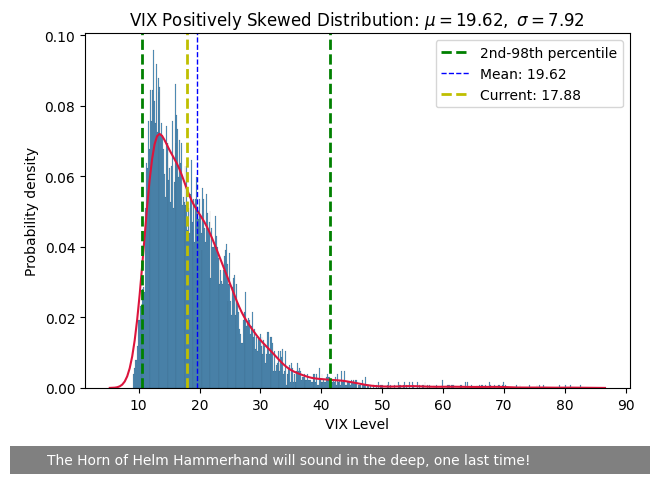

1-sigma move: 25.78
2-sigma move: 33.74
3-sigma move: 41.67


In [14]:
from scipy import stats as st
import seaborn as sns
import numpy

if __name__ == "__main__":
    
    last = 0
    
    def signaturebar(fig,text,fontsize=10,pad=5,xpos=20,ypos=7.5,
                 rect_kw = {"facecolor":"grey", "edgecolor":None},
                 text_kw = {"color":"w"}):
        w,h = fig.get_size_inches()
        height = ((fontsize+2*pad)/72.)/h
        rect = plt.Rectangle((0,0),1,height, transform=fig.transFigure, clip_on=False,**rect_kw)
        fig.axes[0].add_patch(rect)
        fig.text(xpos/72./h, ypos/72./h, text,fontsize=fontsize,**text_kw)
        fig.subplots_adjust(bottom=fig.subplotpars.bottom+height)
    
    def plot_price_paths_whs(vixDf):
            
        mu = np.average(vixDf['CLOSE'])  # mean of distribution
        nparr = np.array(vixDf['CLOSE'])
        mode = st.mode(nparr)
        print('mode:', mode)
        last_reading = vixDf['CLOSE'][-1]
#         sigma = np.std(vixDf['CLOSE'])  # standard deviation of distribution
        current_percentile = numpy.percentile(vixDf['CLOSE'], last_reading)
        print('current percentile: ', current_percentile)
        num_bins = 500
        
        _, sigma = st.norm.fit(vixDf['CLOSE'])
        fig, ax = plt.subplots()
        
        sns.histplot(vixDf['CLOSE'], bins = 500,line_kws={'ls': ':', 'lw':2},stat='density')
        sns.kdeplot(vixDf['CLOSE'], color='crimson')

        ax.set_xlabel('VIX Level')
        ax.set_ylabel('Probability density')
        ax.set_title(f'VIX Positively Skewed Distribution: $\mu={round(mu, 2)},\ \sigma={round(sigma, 2)}$')
        
        fig.tight_layout() # Tweak spacing to prevent clipping of ylabel
        #1 std percentiles: 16 -> 84 
        #2 std percentiles: 2 --> 98
        ax.axvline(np.percentile(vixDf,2), color='g', linestyle='dashed', linewidth=2, label = '2nd-98th percentile')
        ax.axvline(np.percentile(vixDf,98), color='g', linestyle='dashed', linewidth=2)
        ax.axvline(mu, color='b', linestyle='dashed', linewidth=1, label = f'Mean: {round(mu, 2)}')
        ax.axvline(last_reading, color='y', linestyle='dashed', linewidth=2, label = f'Current: {last_reading}')
        plt.legend(loc ="upper right")
        signaturebar(fig,"The Horn of Helm Hammerhand will sound in the deep, one last time!")

        plt.show()
        #legend
        return last_reading
        
#         plt.show()
    # ------------ method for plotting historical + price paths ------------
    
    vixDf = update_data()
    print(vixDf.tail(5))
    last = plot_price_paths_whs(vixDf)
    
    sig1, sig2, sig3 = last+7.9, last+2*7.93, last+3*7.93
    print("1-sigma move:", round(sig1, 2))
    print("2-sigma move:", round(sig2, 2))
    print("3-sigma move:", round(sig3, 2))